In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import sys
basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')


# Hybrid Closed Loop

This is another implementation of the closed-loop forecaster which takes derivatives on the mesh rather than in the pullback space. We find that this yields equivalent performance to the closed loop implemented purely in pullback space

Calibrating flow model to movie intensity
Building mesh gradient operators
Loading order 0 from file
Loading order 1 from file
Loading order 2 from file
Initializing
Using torchdiffeq solver


(<Figure size 1250x900 with 17 Axes>, <Figure size 250x250 with 1 Axes>)

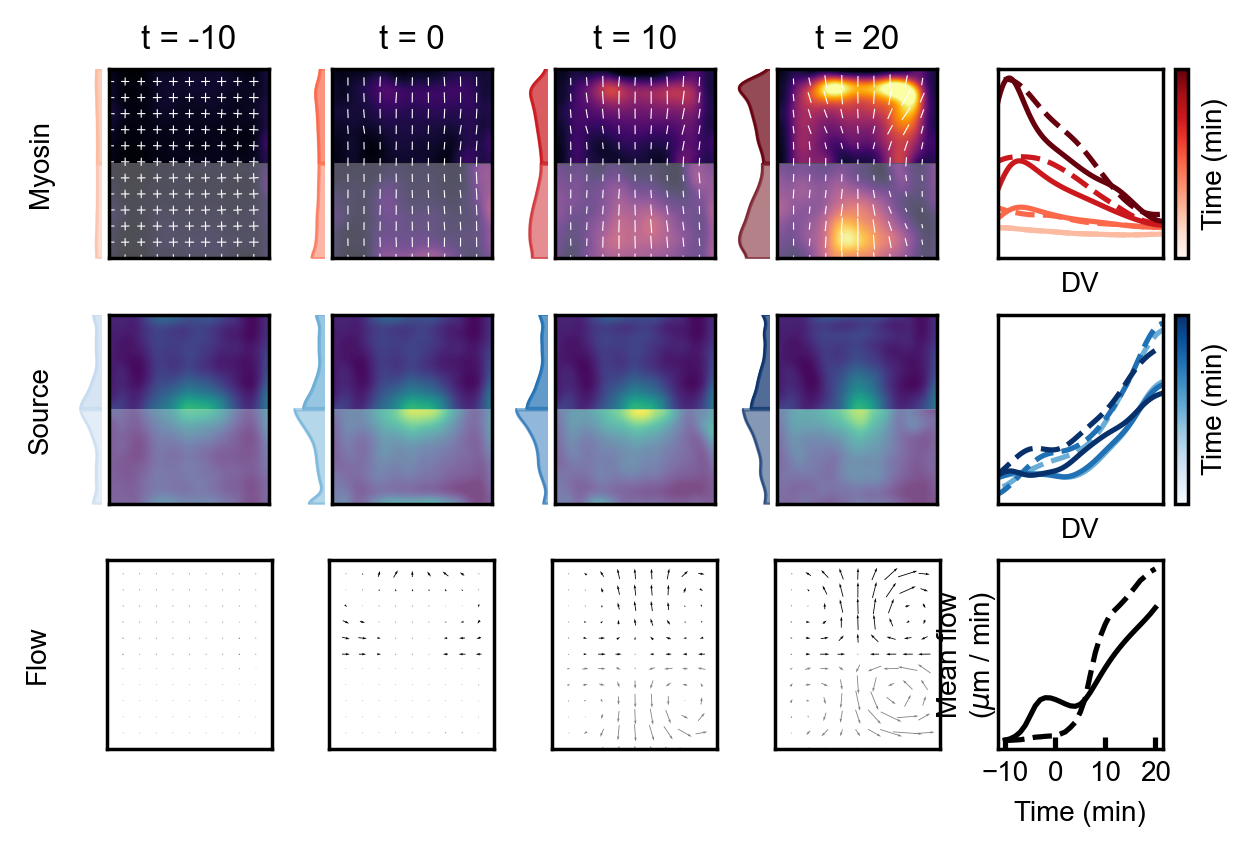

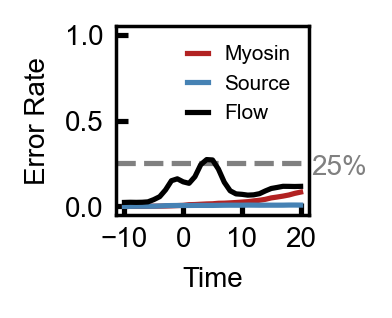

In [7]:
import torch
from sklearn.preprocessing import MinMaxScaler
from utils.decomposition.decomposition_model import LeftRightSymmetrize
from utils.geometry.hybrid_loop import HybridClosedLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../tb_logs/May2023/MaskedVAE_Evolver_sqh_beta=0_split=embryo')
info = torch.load('../tb_logs/May2023/forecasting_vae_v3.ckpt') #Works well with sigma = 3

vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])

vae = vae.double().to(device).eval();

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    
    #s0 = LeftRightSymmetrize().fit_transform(s0)
    t0 = t[t_mask, ...][()]
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0]
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
]) 
y0 = torch.from_numpy(y0)

model = HybridClosedLoop(v_model=v_model, 
                         sigma=7, 
                         mesh_name='embryo_poles_noll')
model.fit(y0[None])
model.to(device)
y0 = y0.to(device)

m, s, v = model.integrate(y0, t0)
comparison_plot(t0,
                ('Myosin', m, m0),
                ('Source', s, s0),
                ('Flow', v, v0),
                dt=10)